# Evolutionary strategies

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import objective_functions
from scipy import interpolate
import utils
import plots

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from collections import namedtuple

%matplotlib inline

## Evolutionary strategy example

In [3]:
Records = namedtuple("Records", ["best_solution_objective_value", "best_solution", "log_objective_values", "log_best_solutions", "log_best_sigmas"])

def es(objective_function, chromosome_length, population_size, number_of_iterations, number_of_offspring, number_of_parents, sigma, tau, tau_0, log_frequency=1, domain=[-np.inf, np.inf]):

    best_solution = np.empty((1, chromosome_length))
    best_solution_objective_value = 0.00

    log_objective_values = np.empty((number_of_iterations, 4))
    log_best_solutions = np.empty((number_of_iterations, chromosome_length))
    log_best_sigmas = np.empty((number_of_iterations, chromosome_length))

    # generating an initial population
    current_population_solutions = 100.0 * np.random.rand(population_size, chromosome_length)
    current_population_sigmas = sigma * np.ones((population_size, chromosome_length))

    # evaluating the objective function on the current population
    current_population_objective_values = objective_function(current_population_solutions)

    for t in range(number_of_iterations):

        # selecting the parent indices by the roulette wheel method
        fitness_values = current_population_objective_values - current_population_objective_values.min()
        if fitness_values.sum() > 0:
            fitness_values = fitness_values / fitness_values.sum()
        else:
            fitness_values = 1.0 / population_size * np.ones(population_size)
        parent_indices = np.random.choice(population_size, (number_of_offspring, number_of_parents), True, fitness_values).astype(np.int64)

        # creating the children population by Global Intermediere Recombination
        children_population_solutions = np.zeros((number_of_offspring, chromosome_length))
        children_population_sigmas = np.zeros((number_of_offspring, chromosome_length))
        for i in range(number_of_offspring):
            children_population_solutions[i, :] = current_population_solutions[parent_indices[i, :], :].mean(axis=0)
            children_population_sigmas[i, :] = current_population_sigmas[parent_indices[i, :], :].mean(axis=0)

        # mutating the children population by adding random gaussian noise
        children_population_sigmas = children_population_sigmas * np.exp(tau * np.random.randn(number_of_offspring, chromosome_length) + tau_0 * np.random.randn(number_of_offspring, 1))
        children_population_solutions = children_population_solutions + children_population_sigmas * np.random.randn(number_of_offspring, chromosome_length)

        # enforcing domain restriction
        floor = np.full(children_population_solutions.shape, domain[0])
        ceiling = np.full(children_population_solutions.shape, domain[1])
        children_population_solutions = np.maximum(children_population_solutions, floor)
        children_population_solutions = np.minimum(children_population_solutions, ceiling)

        # evaluating the objective function on the children population
        children_population_objective_values = objective_function(children_population_solutions)

        # replacing the current population by (Mu + Lambda) Replacement
        current_population_objective_values = np.hstack([current_population_objective_values, children_population_objective_values])
        current_population_solutions = np.vstack([current_population_solutions, children_population_solutions])
        current_population_sigmas = np.vstack([current_population_sigmas, children_population_sigmas])

        I = np.argsort(current_population_objective_values)[::-1]
        current_population_solutions = current_population_solutions[I[:population_size], :]
        current_population_sigmas = current_population_sigmas[I[:population_size], :]
        current_population_objective_values = current_population_objective_values[I[:population_size]]

        # recording some statistics
        if best_solution_objective_value < current_population_objective_values[0]:
            best_solution = current_population_solutions[0, :]
            best_solution_objective_value = current_population_objective_values[0]
        log_objective_values[t, :] = [current_population_objective_values.min(), current_population_objective_values.max(), current_population_objective_values.mean(), current_population_objective_values.std()]
        log_best_solutions[t, :] = current_population_solutions[0, :]
        log_best_sigmas[t, :] = current_population_sigmas[0, :]

        # if np.mod(t, log_frequency) == 0:
        #     print("Iteration %04d : best score = %0.8f, mean score = %0.8f." % (t, log_objective_values[:t+1, 1].max(), log_objective_values[t, 2]))

    return Records(best_solution_objective_value, best_solution, log_objective_values, log_best_solutions, log_best_sigmas)

## Run benchamrks for different dimensionalities

In [4]:
domains = {
	objective_functions.F1: (-5, 5),
	objective_functions.F6: (-5, 5),
	objective_functions.F7: (-500, 500),
	objective_functions.F8: (-100, 100)
}

In [4]:
def simulation(f, d):
	N = 2000; T = 100
	return es(f, d, N, T, 2*N, 2, 50.0, 1/np.sqrt(2*d), 1/np.sqrt(2*np.sqrt(d)), 10, domain=domains[f])

In [5]:
def plot_results(arch, f, d):
	records = arch.where("benchmark", f).where("dimension", d).pick("f")[0]
	print("best:", max(records.log_objective_values[:, 1]))
	utils.quickplot(
		records.log_objective_values[:, 0],
		records.log_objective_values[:, 1],
		records.log_objective_values[:, 2],
		ylabel="objective function value",
		title=f"min/avg/max objective function values for {d} dimensions",
		marker="r-"
	)
	utils.quickplot(
		records.log_best_sigmas,
		ylabel="sigma value",
		title="best sigma",
		marker="orange"
	)

In [6]:
benchmarks = utils.Archives(
	simulation,
	benchmark = [
		objective_functions.F1,
		objective_functions.F6,
		objective_functions.F7,
		objective_functions.F8
	],
	dimension = [10, 20, 50, 100]
)

### Sphere

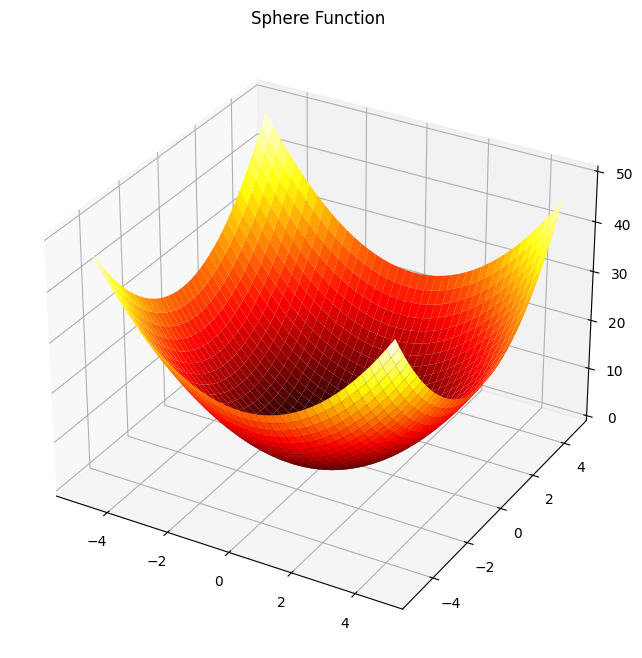

best: -7.356963801319628e-25


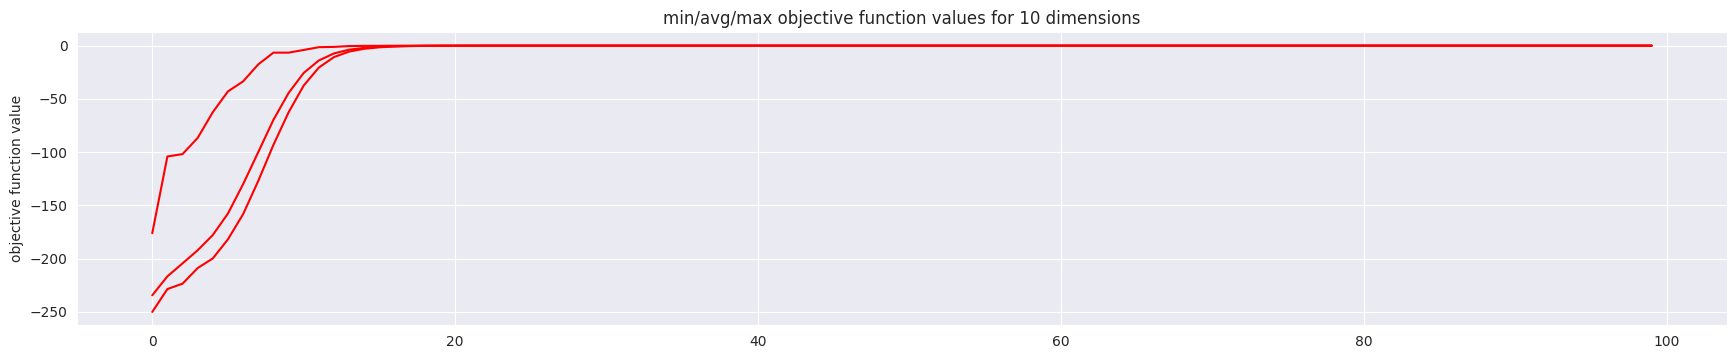

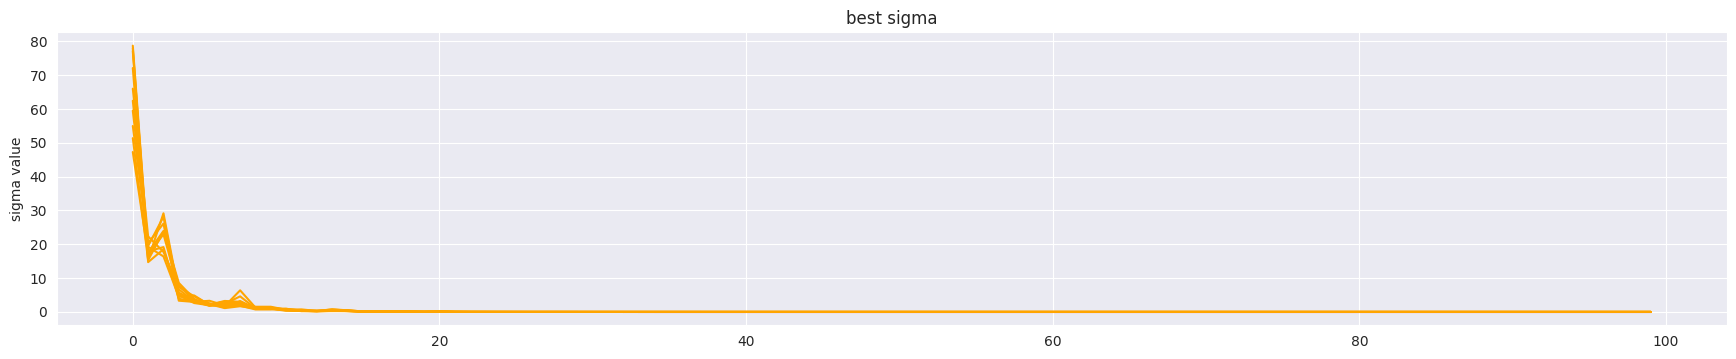

best: -5.5293247331004076e-15


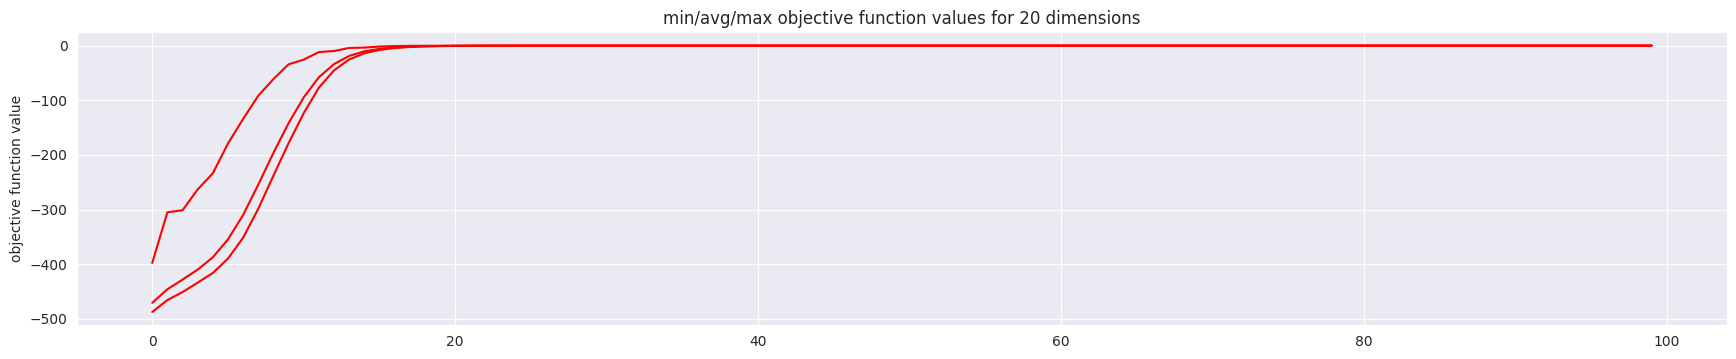

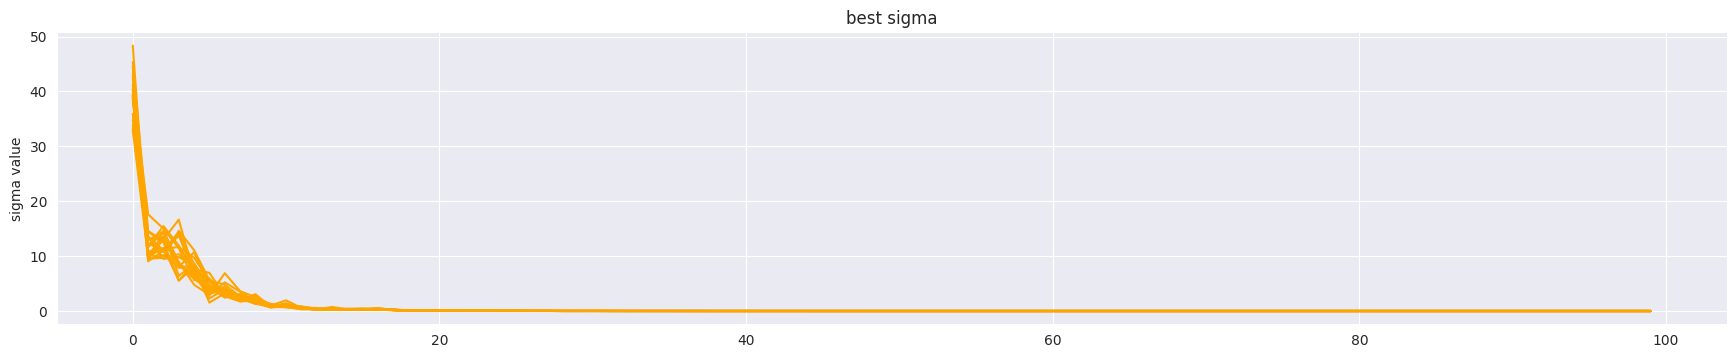

best: -1.4113339632298833e-06


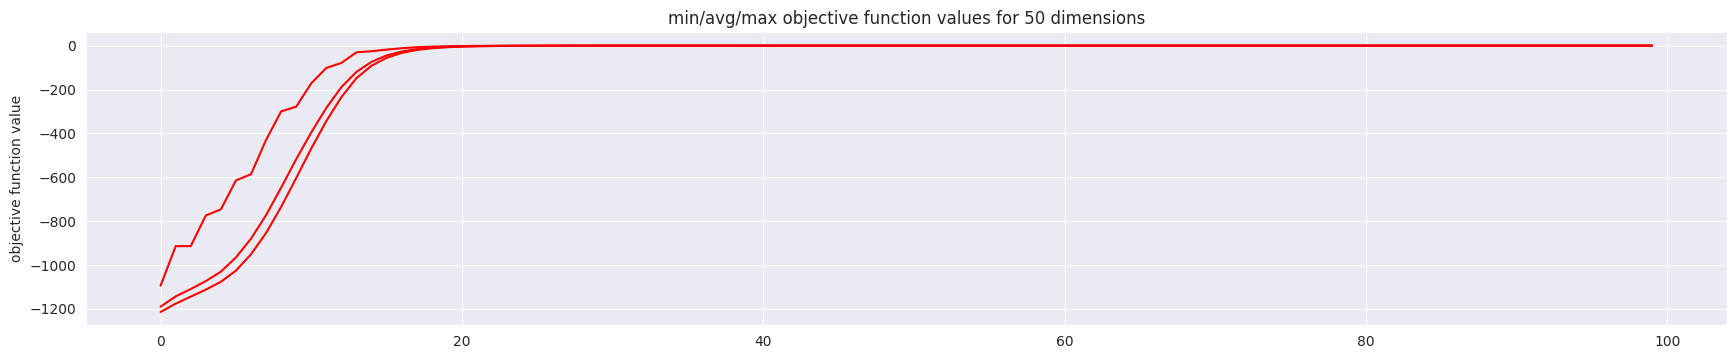

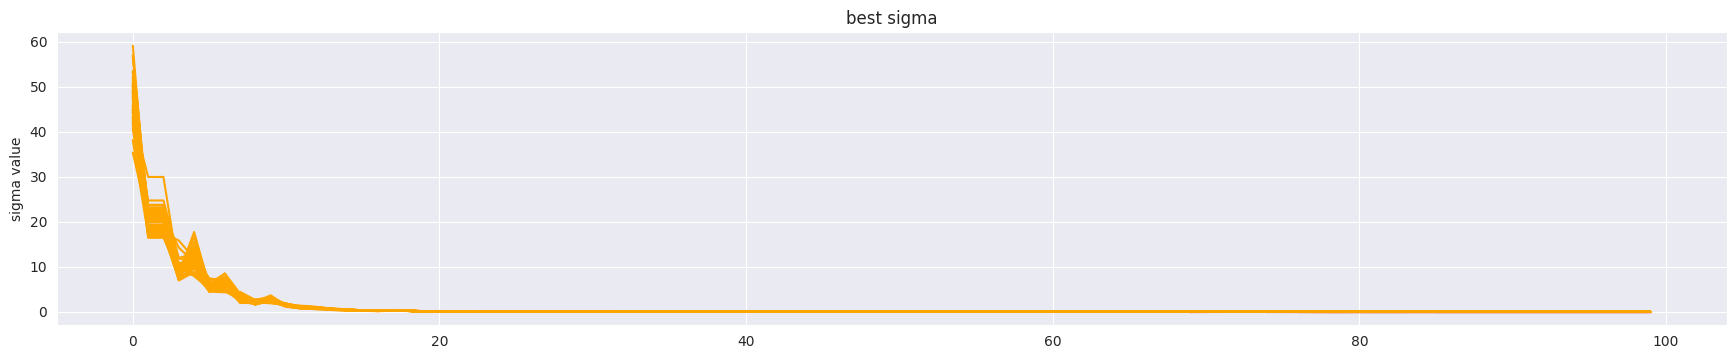

best: -0.005040372653690148


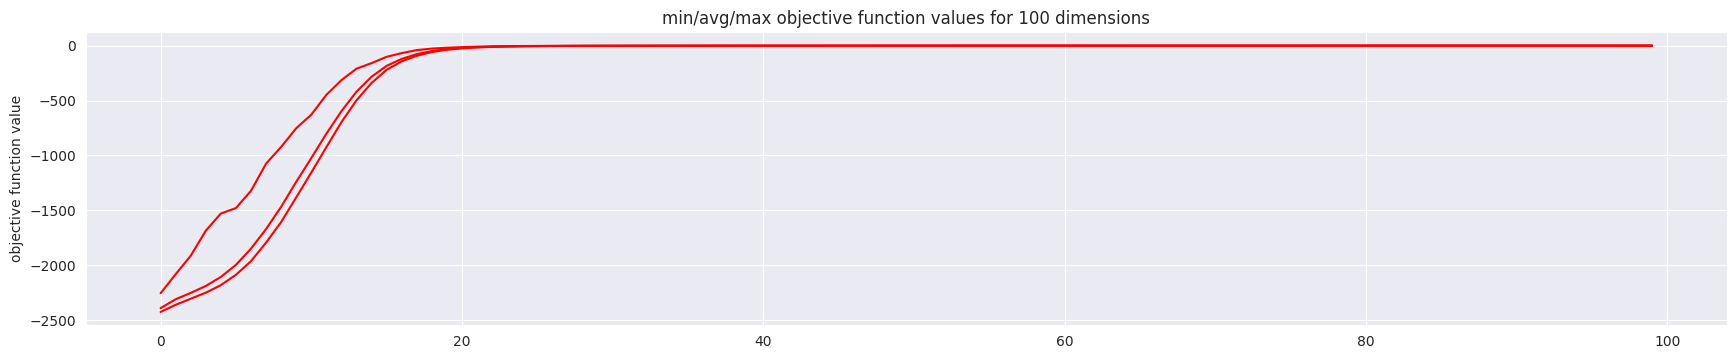

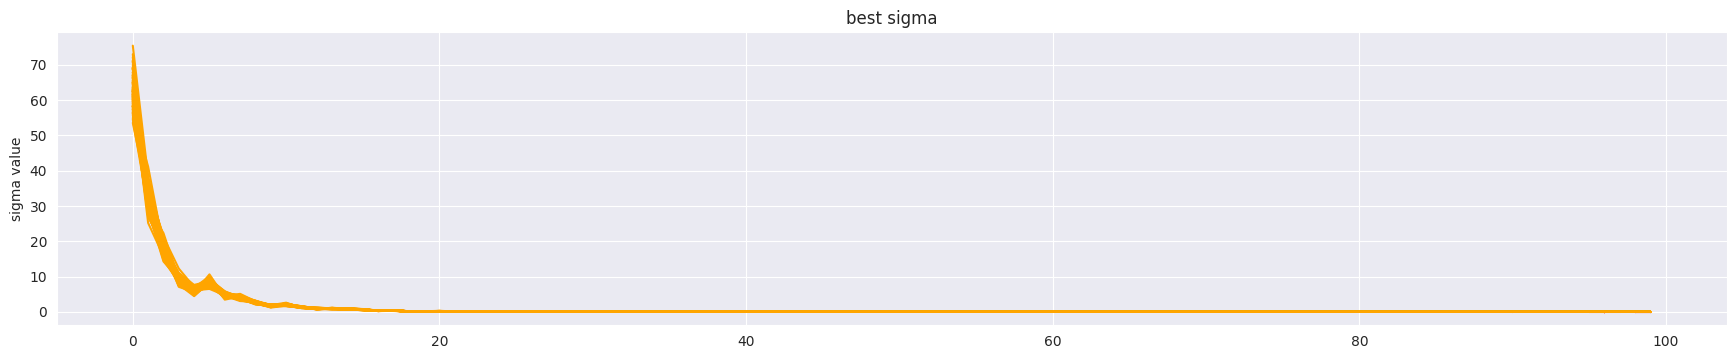

In [7]:
domain = np.arange(-5, 5, 0.25)
plots.plot_3D_benchmark_function(objective_functions.F1, domain, domain, 'Sphere Function')
plot_results(benchmarks, objective_functions.F1, 10)
plot_results(benchmarks, objective_functions.F1, 20)
plot_results(benchmarks, objective_functions.F1, 50)
plot_results(benchmarks, objective_functions.F1, 100)

### Rastrigin

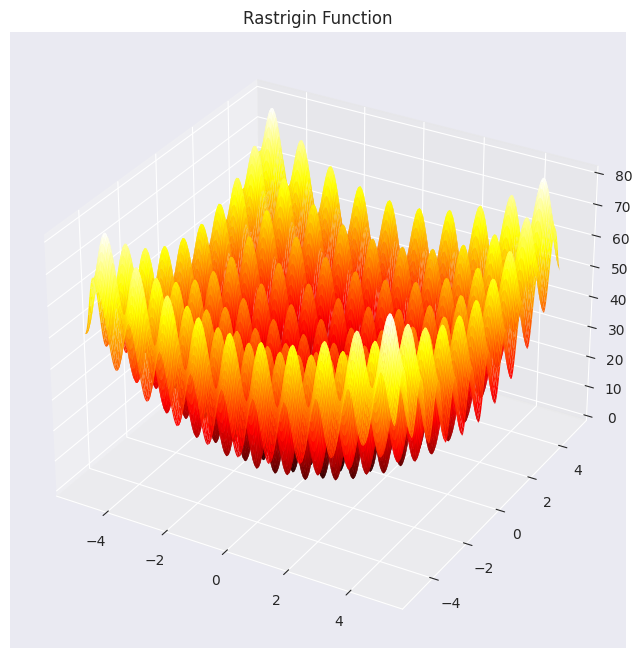

best: 0.0


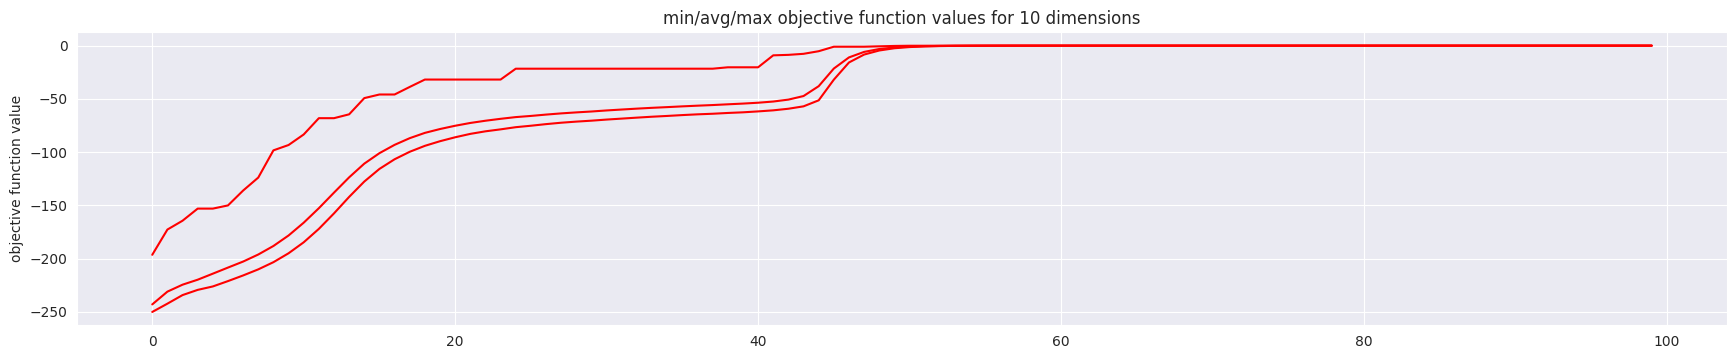

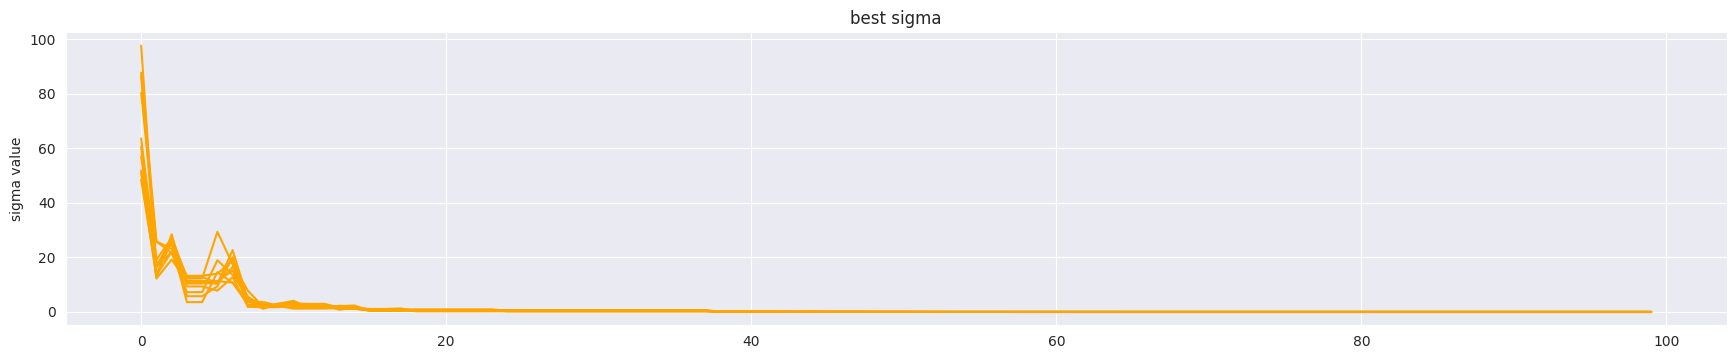

best: -4.806111064681318e-09


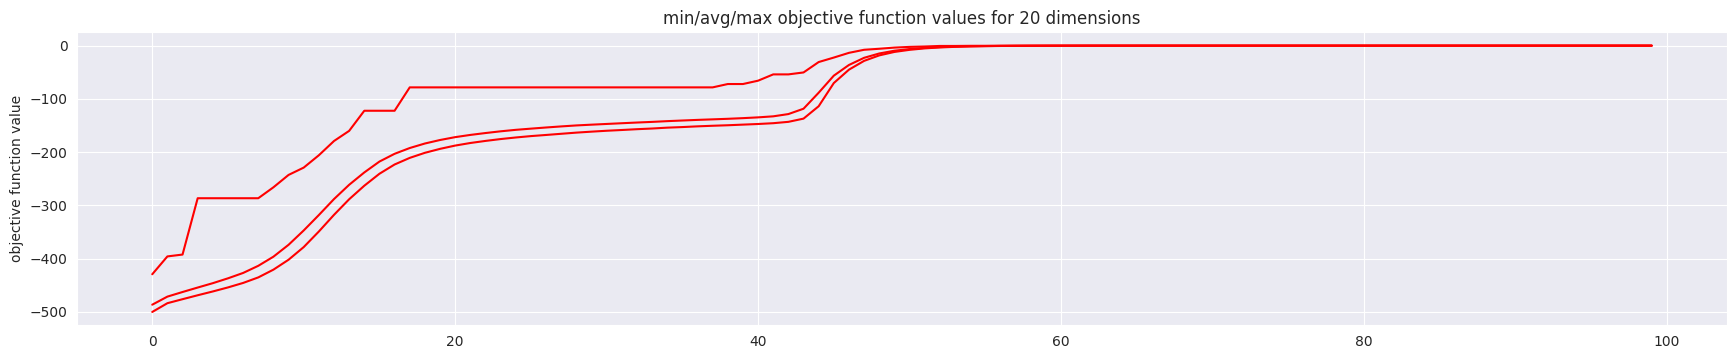

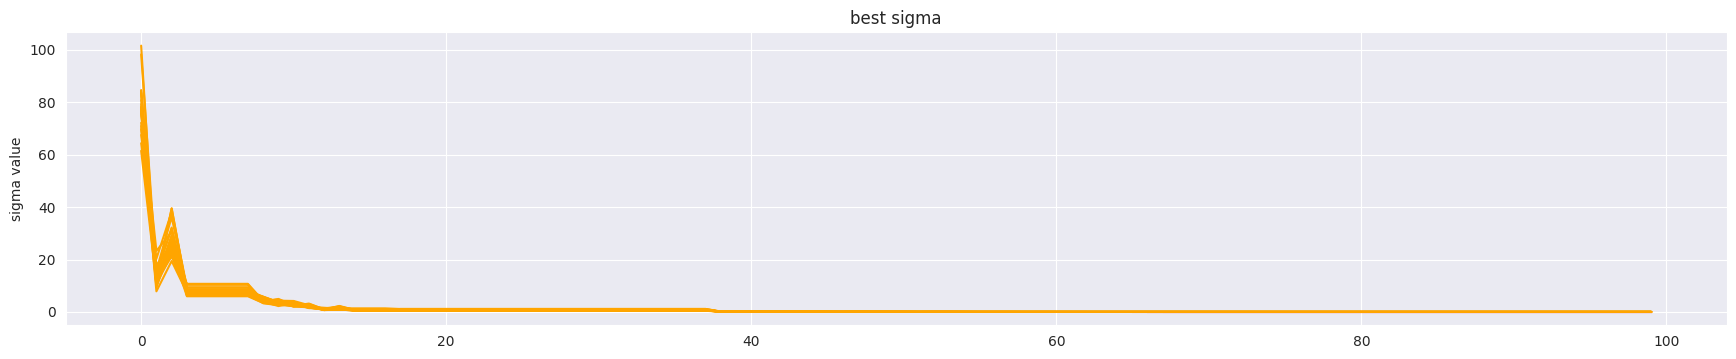

best: -1.0138601550419253


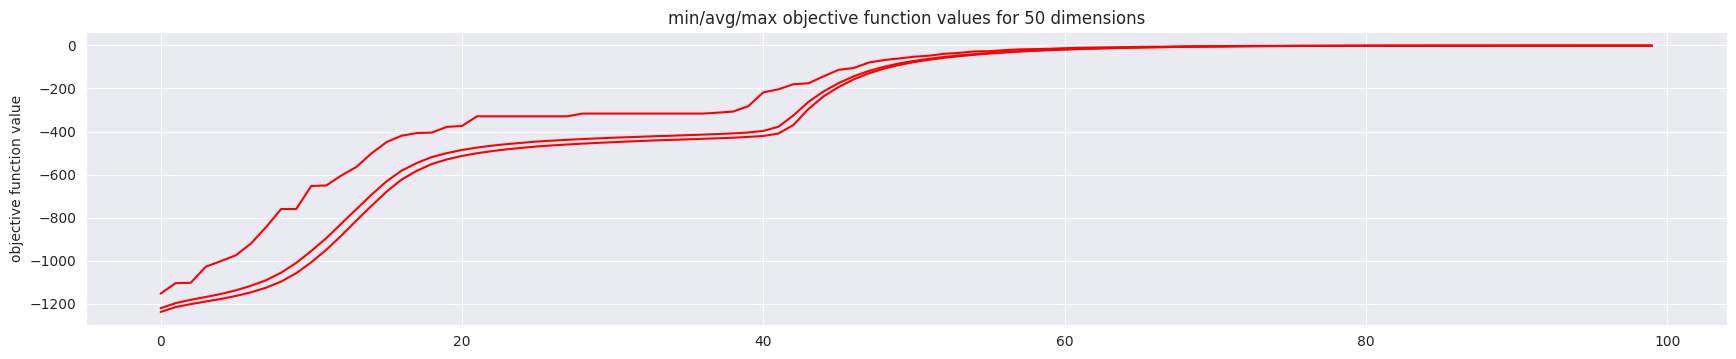

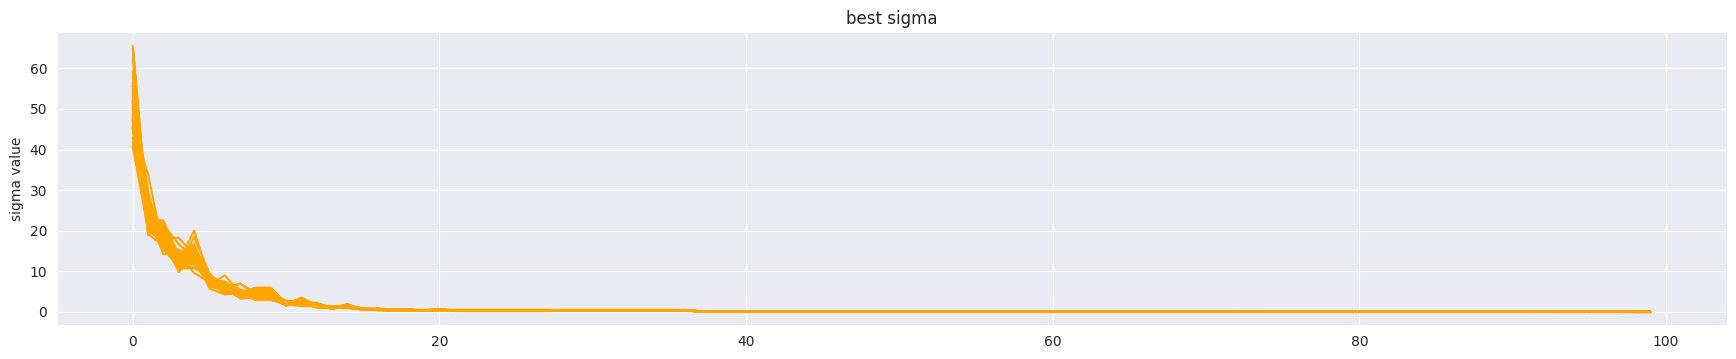

best: -11.537674024491025


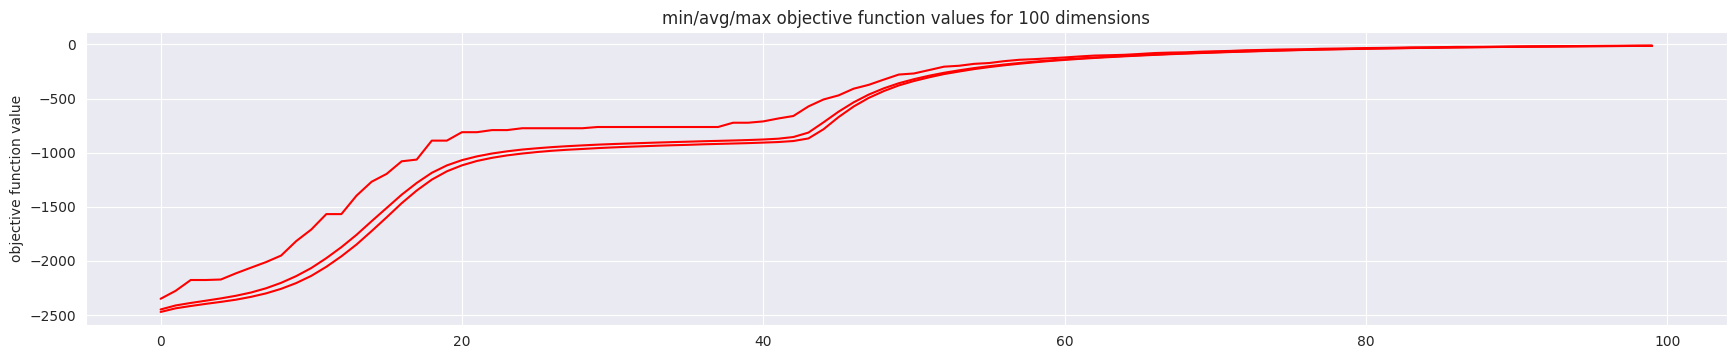

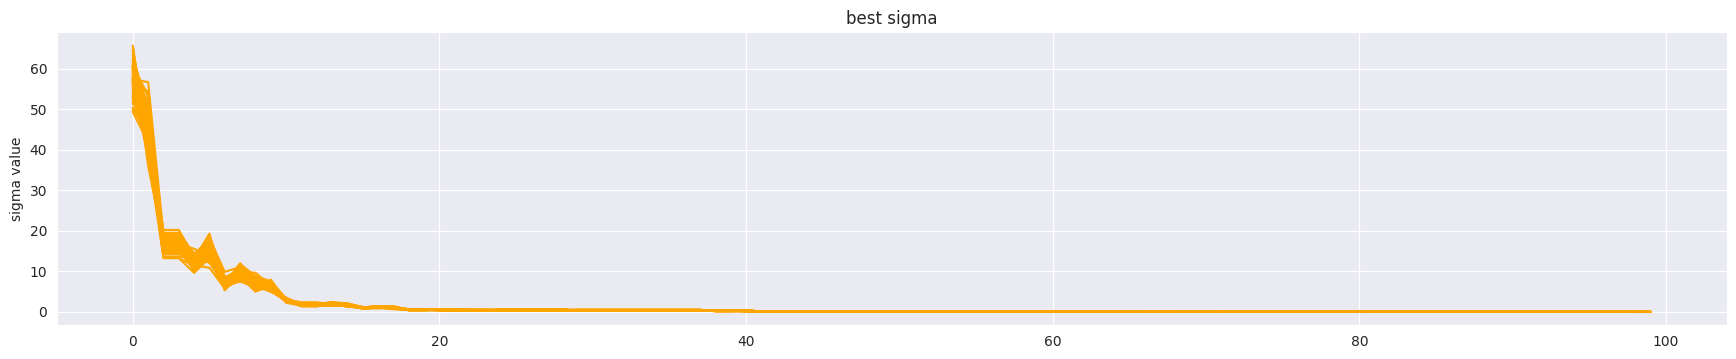

In [8]:
domain = np.arange(-5, 5, 0.05)
plots.plot_3D_benchmark_function(objective_functions.F6, domain, domain, 'Rastrigin Function')
plot_results(benchmarks, objective_functions.F6, 10)
plot_results(benchmarks, objective_functions.F6, 20)
plot_results(benchmarks, objective_functions.F6, 50)
plot_results(benchmarks, objective_functions.F6, 100)

### Schwefel

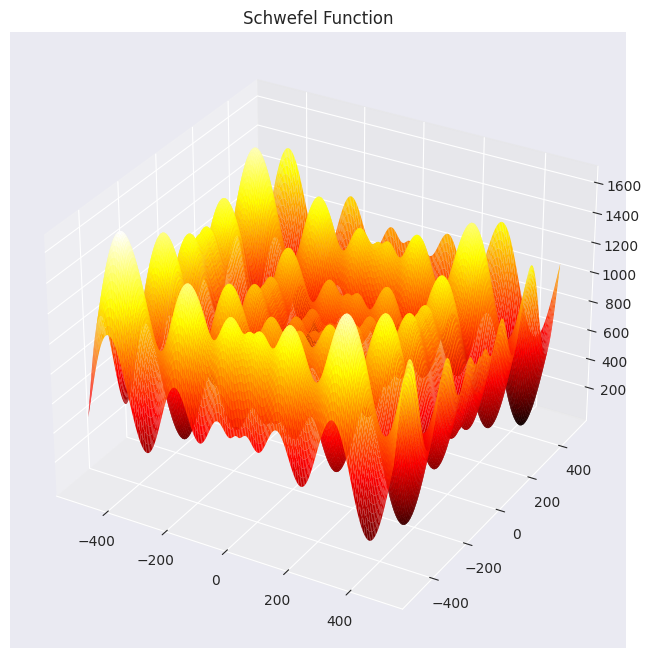

best: -1742.607689692752


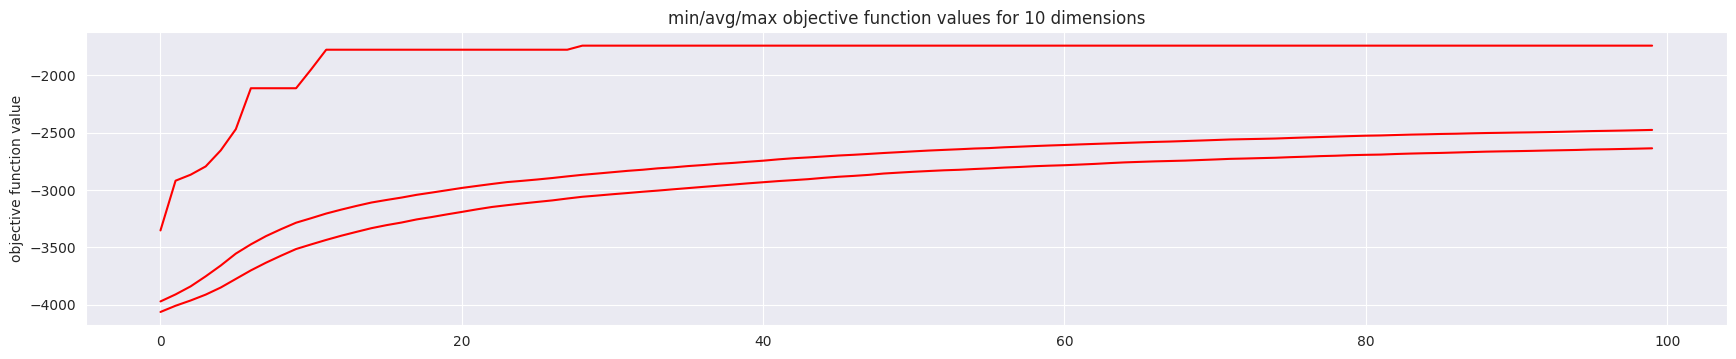

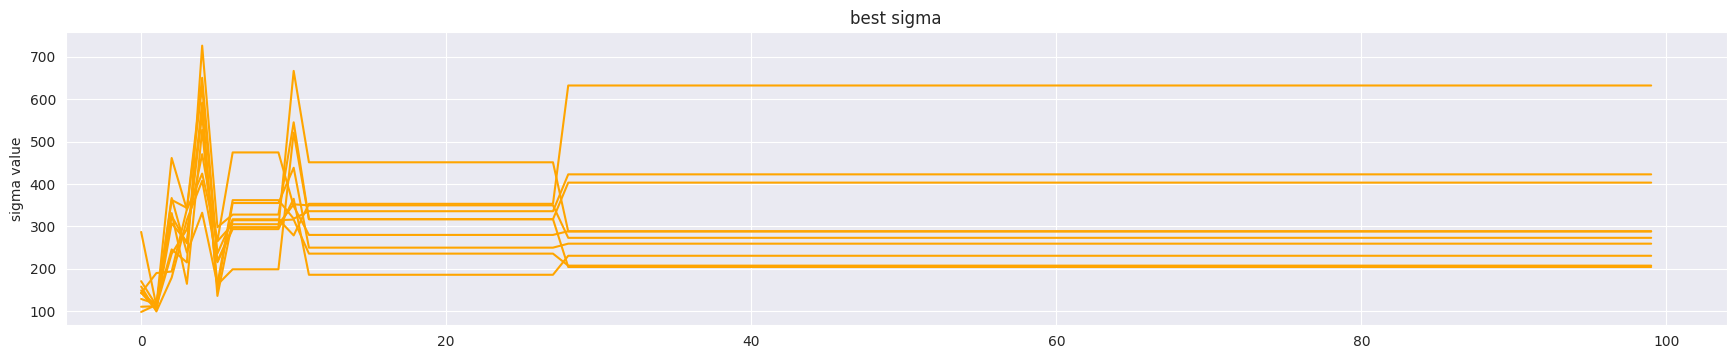

best: -4360.251079266218


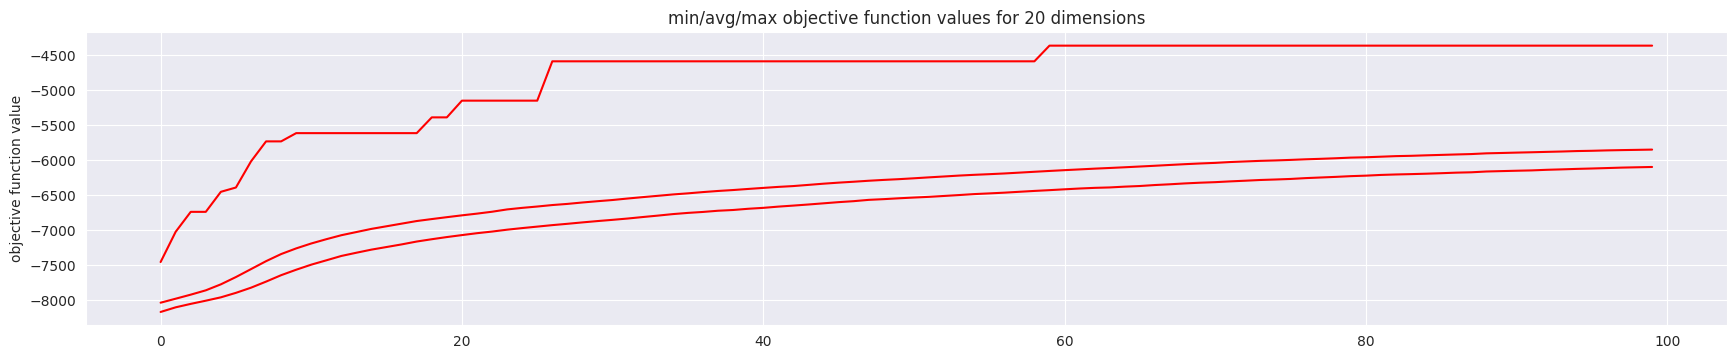

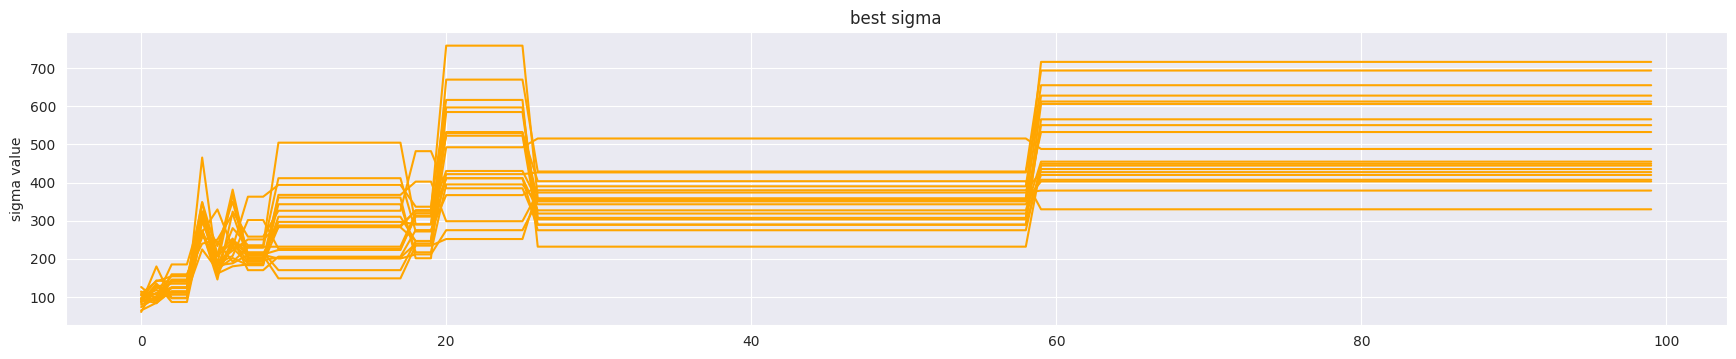

best: -15217.929529736906


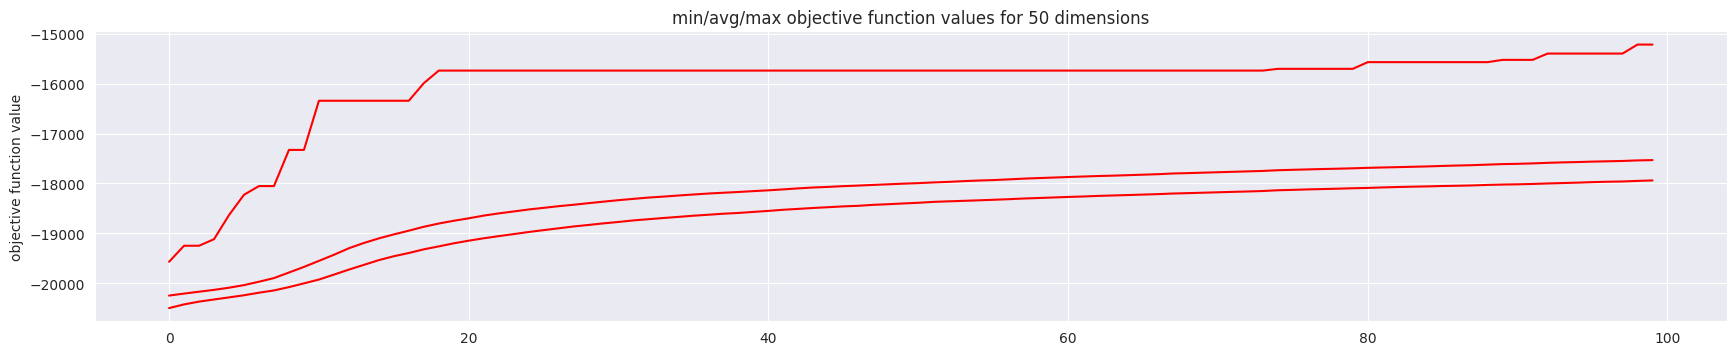

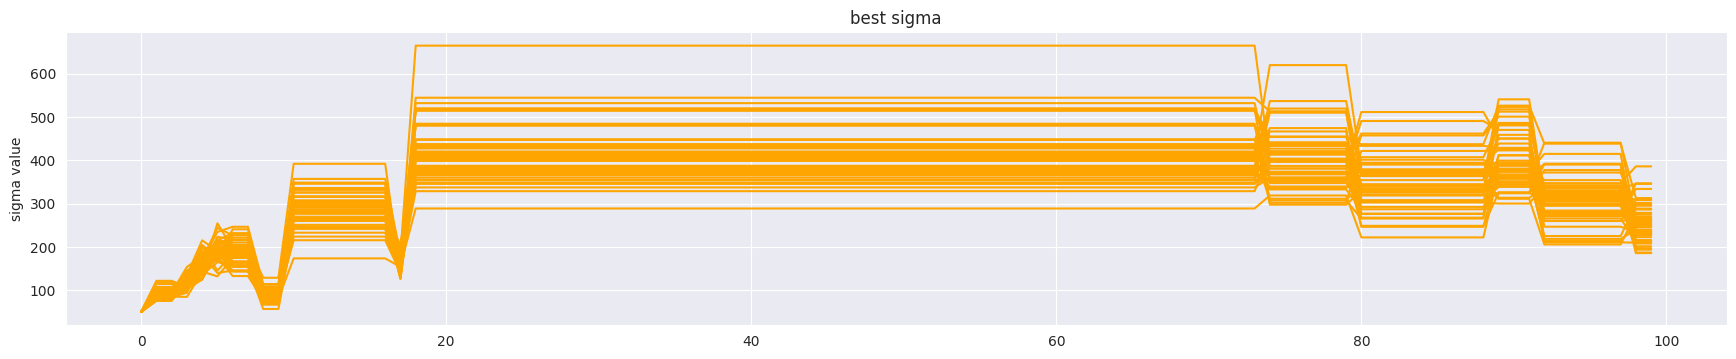

best: -35537.90779182382


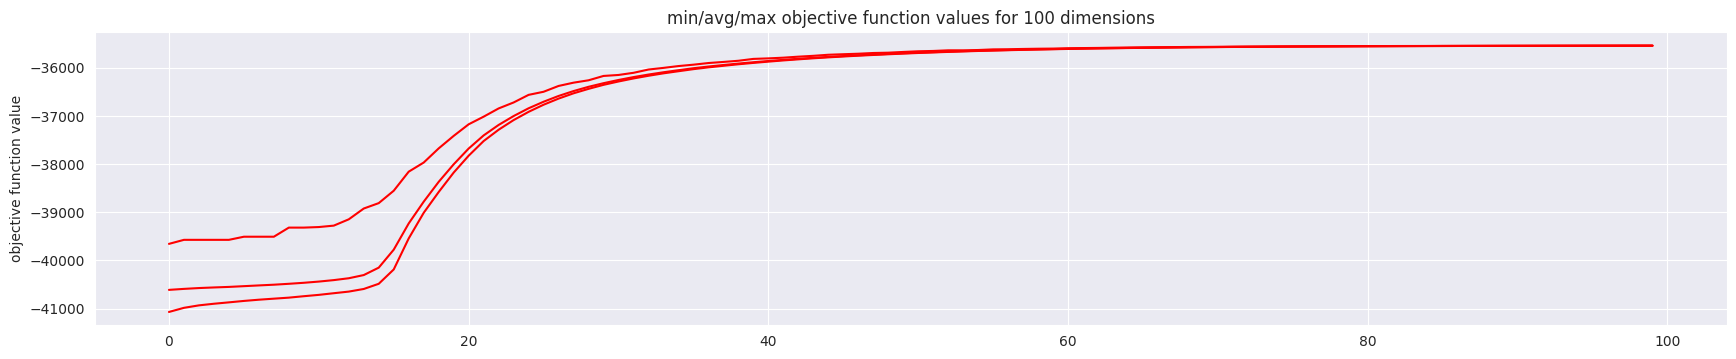

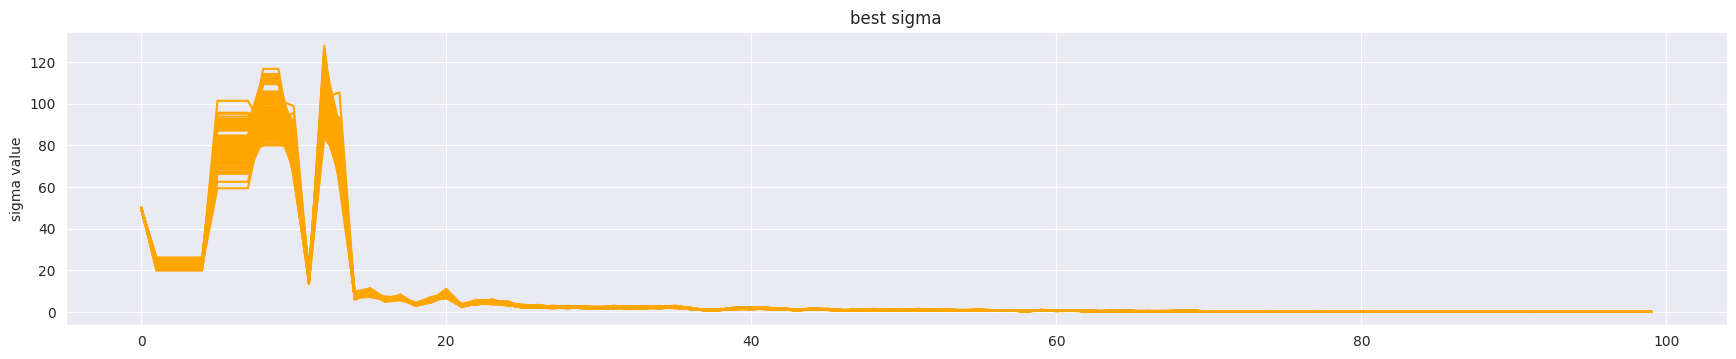

In [9]:
domain = np.arange(-500, 500, 5)
plots.plot_3D_benchmark_function(objective_functions.F7, domain, domain, 'Schwefel Function')
plot_results(benchmarks, objective_functions.F7, 10)
plot_results(benchmarks, objective_functions.F7, 20)
plot_results(benchmarks, objective_functions.F7, 50)
plot_results(benchmarks, objective_functions.F7, 100)

### Griewank

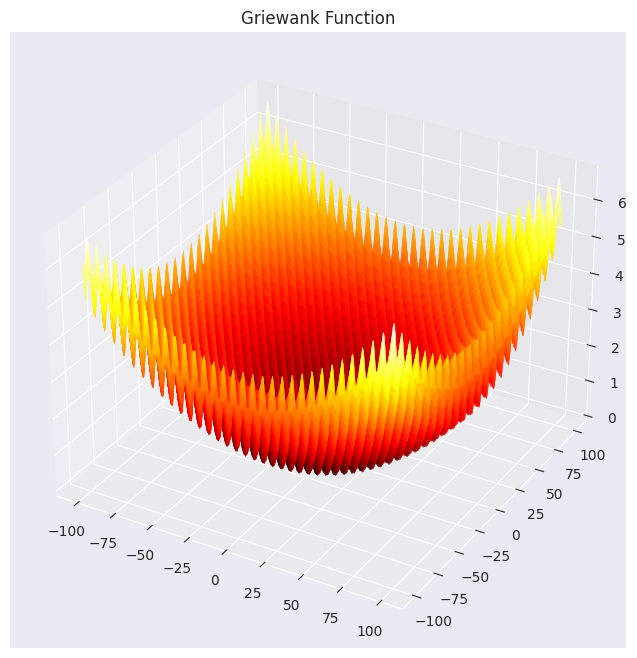

best: -0.012316072519261256


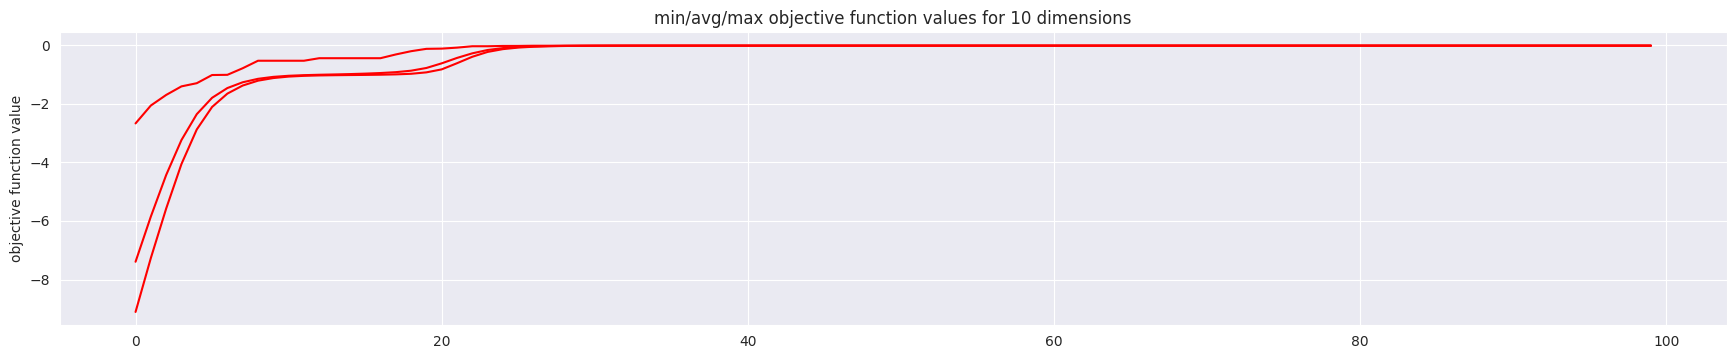

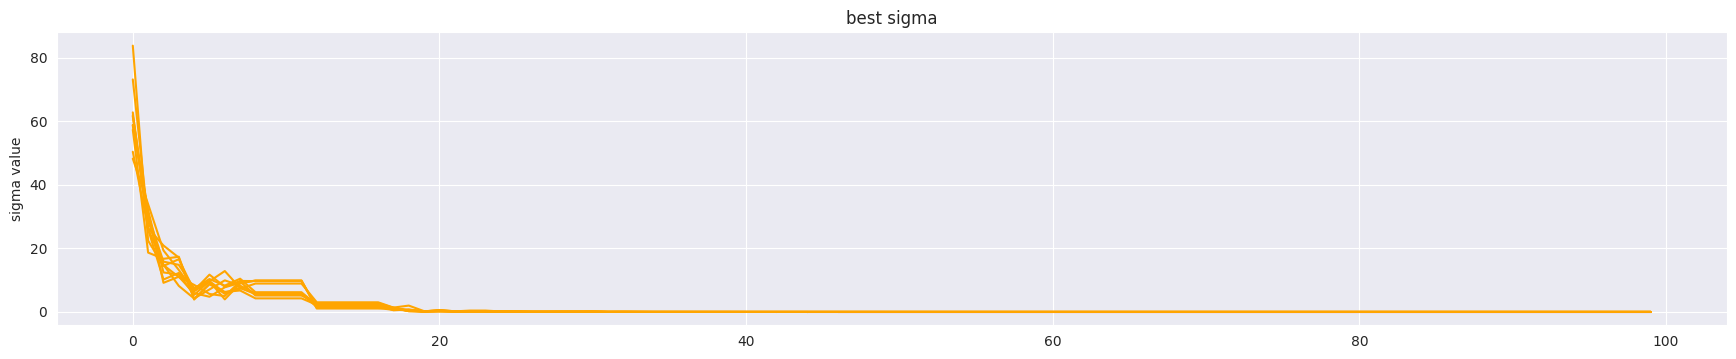

best: -1.1255618659333777e-10


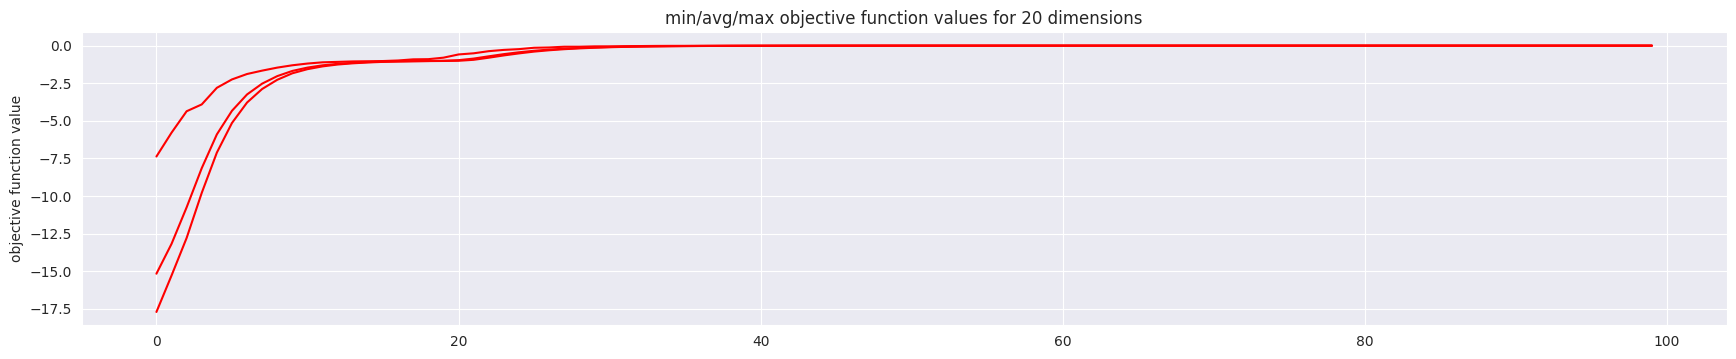

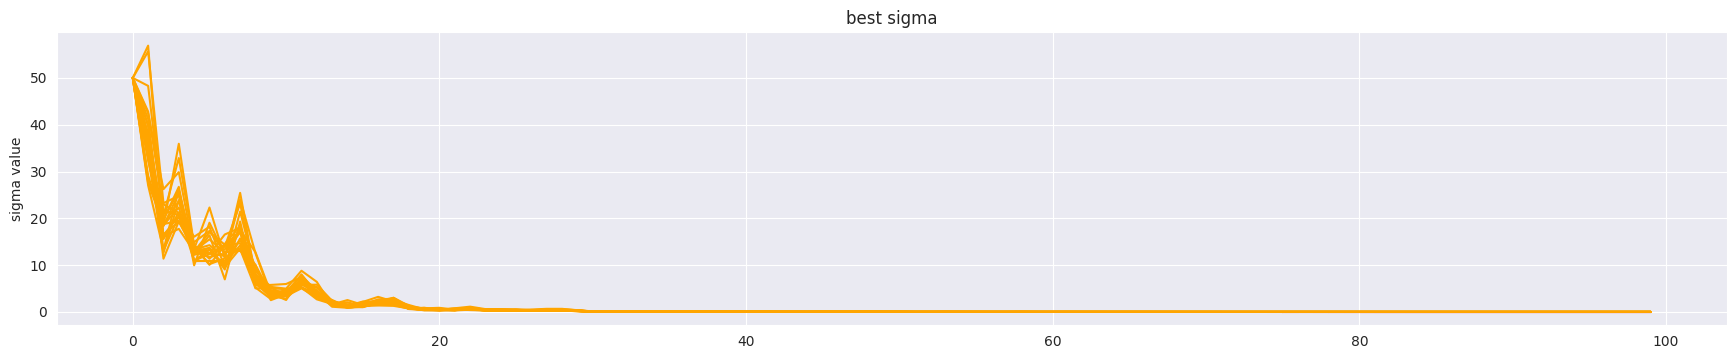

best: -0.03466188700685868


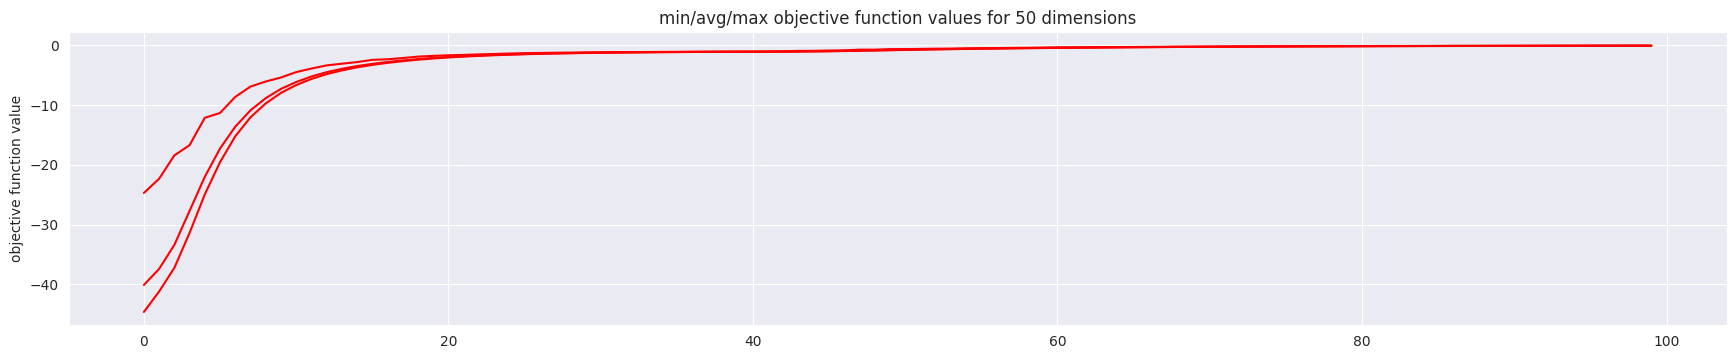

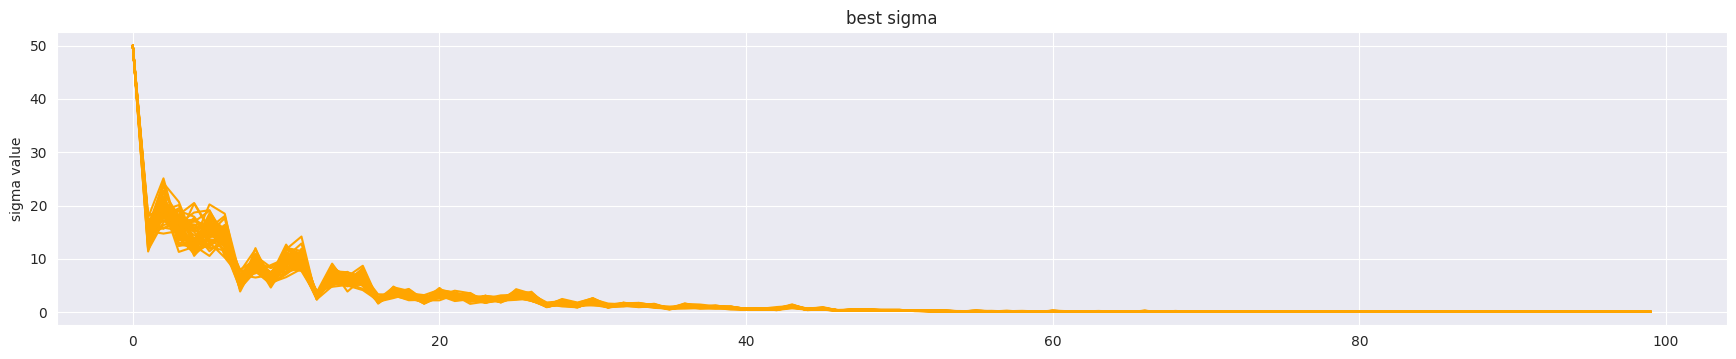

best: -0.7519670883565901


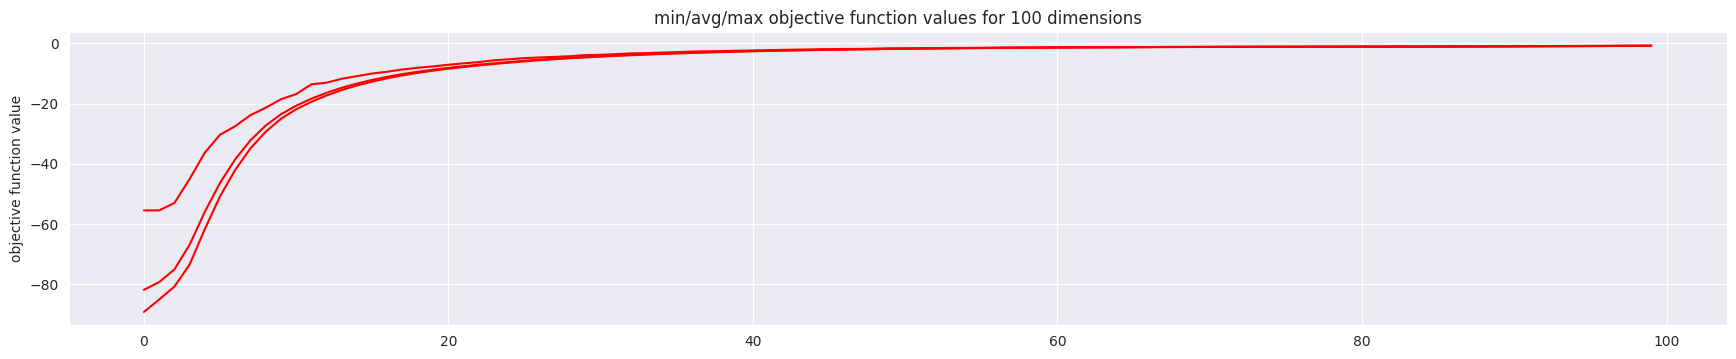

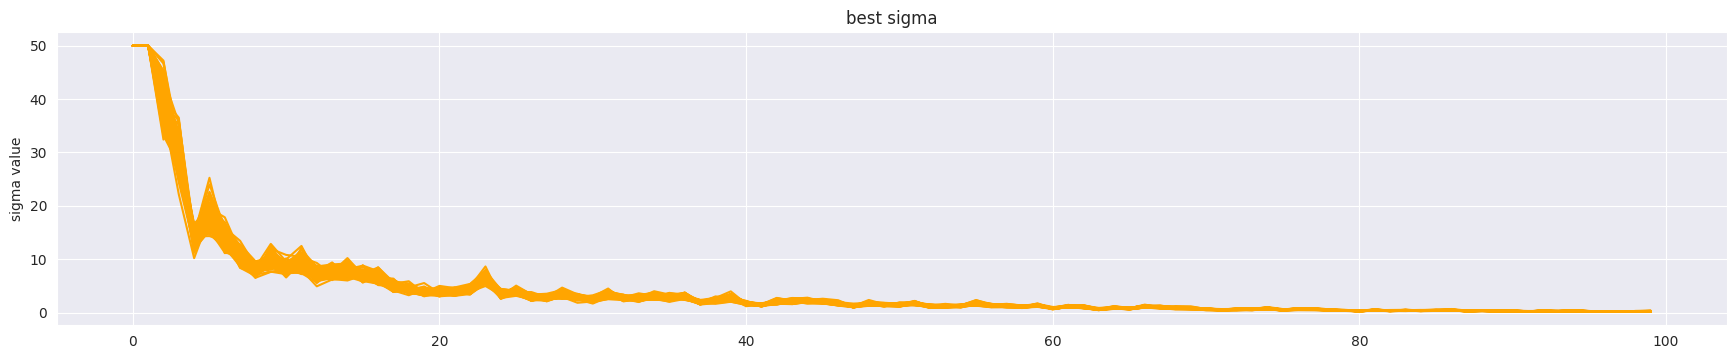

In [10]:
domain = np.arange(-100, 100, 0.5)
plots.plot_3D_benchmark_function(objective_functions.F8, domain, domain, 'Griewank Function')
plot_results(benchmarks, objective_functions.F8, 10)
plot_results(benchmarks, objective_functions.F8, 20)
plot_results(benchmarks, objective_functions.F8, 50)
plot_results(benchmarks, objective_functions.F8, 100)

## Parameter testing

In [6]:
def es_best(*args, **kwargs):
	records = es(*args, **kwargs)
	return max(records.log_objective_values[:, 1])

def es_averaged(*args, **kwargs):
	times = 100
	return np.mean([es_best(*args, **kwargs) for _ in range(times)])

### Population vs Offspring

In [12]:
N = 10

def simulation(population, offspring):
	T = 100; f = objective_functions.F7; d = 10
	return es_averaged(f, d, population, T, offspring, 2, 50.0, 1/np.sqrt(2*d), 1/np.sqrt(2*np.sqrt(d)), 10, domain=domains[f])

populations = utils.Archives(
	simulation,
	population = (np.arange(N) + 1) * 10,
	offspring = (np.arange(N) + 1) * 10
)

In [13]:
data = populations.data
X = data.iloc[:, 0].to_numpy().reshape((N, N))
Y = data.iloc[:, 1].to_numpy().reshape((N, N))
Z = populations.f.to_numpy().reshape((N, N))

In [14]:
np.mean([simulation(20, 100) for _ in range(10)])

-1564.6390390453873

In [15]:
np.mean([simulation(100, 100) for _ in range(10)])

-1884.8587356988992

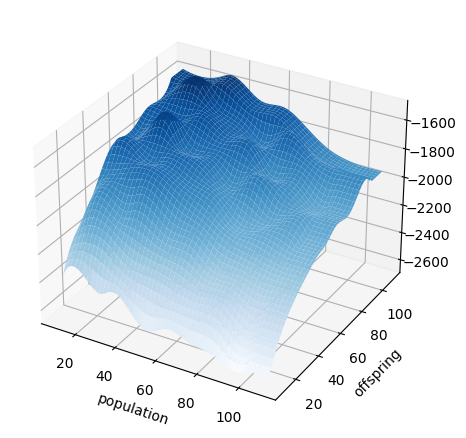

In [19]:
f = interpolate.interp2d(X, Y, Z, kind="cubic")
X_ = (np.linspace(0, N, 100) + 1) * 10
Y_ = (np.linspace(0, N, 100) + 1) * 10
Z_ = f(X_, Y_)
xx, yy = np.meshgrid(X_, Y_)
utils.surfplot(xx, yy, Z_, xaxis="population", yaxis="offspring")

### Tau combinations

In [21]:
N = 10

def simulation(tau, tau0):
	T = 100; f = objective_functions.F7; d = 10
	return es_averaged(f, d, 20, T, 100, 2, 50.0, tau, tau0, 10, domain=domains[f])

ts = utils.Archives(
	simulation,
	tau = np.linspace(0, 1, N),
	tau0 = np.linspace(0, 1, N)
)

In [24]:
simulation(0.1, 0.3)

-1493.706388410827

In [22]:
data = ts.data
X = data.iloc[:, 0].to_numpy().reshape((N, N))
Y = data.iloc[:, 1].to_numpy().reshape((N, N))
Z = ts.f.to_numpy().reshape((N, N))

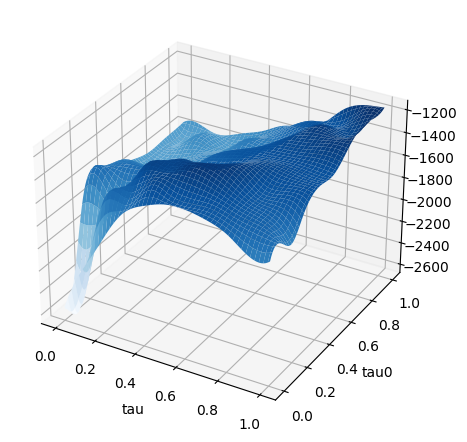

In [26]:
f = interpolate.interp2d(X, Y, Z, kind="cubic")
X_ = np.linspace(0, 1, 100)
Y_ = np.linspace(0, 1, 100)
Z_ = f(X_, Y_)
xx, yy = np.meshgrid(X_, Y_)
utils.surfplot(xx, yy, Z_, xaxis="tau", yaxis="tau0")

### Parent Count

In [36]:
def simulation(parents):
	T = 100; f = objective_functions.F7; d = 10
	return es_averaged(f, d, 20, T, 100, parents, 50.0, 1/np.sqrt(2*d), 1/np.sqrt(2*np.sqrt(d)), 10, domain=domains[f])

X = [simulation(pc) for pc in utils.progress_bar(range(1, 21))]

100%|██████████| 20/20 [06:12<00:00, 18.61s/it]


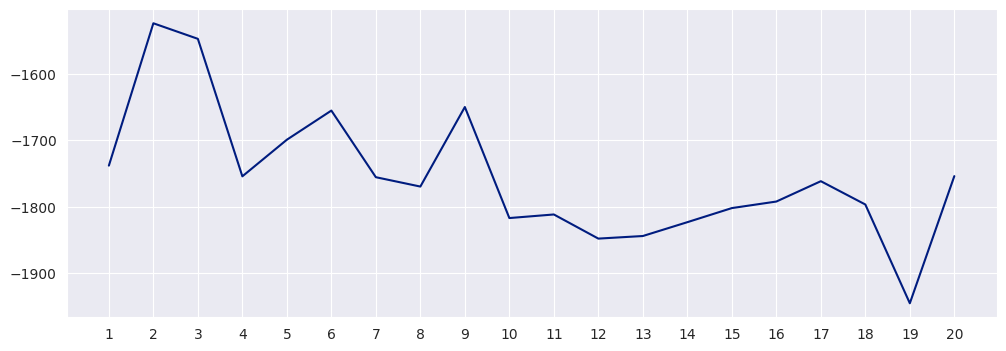

In [51]:
plt.figure(figsize=(12, 4))
plt.plot(np.arange(1, 21), X)
plt.xticks(np.arange(1, 21))
plt.show()

### Starting sigma

In [7]:
def simulation(sigma):
	T = 32; f = objective_functions.F7; d = 10
	return es_averaged(f, d, 10, T, 50, 2, sigma, 1/np.sqrt(2*d), 1/np.sqrt(2*np.sqrt(d)), 10, domain=domains[f])

X = [simulation(s) for s in utils.progress_bar(range(700))]

100%|██████████| 700/700 [35:11<00:00,  3.02s/it]


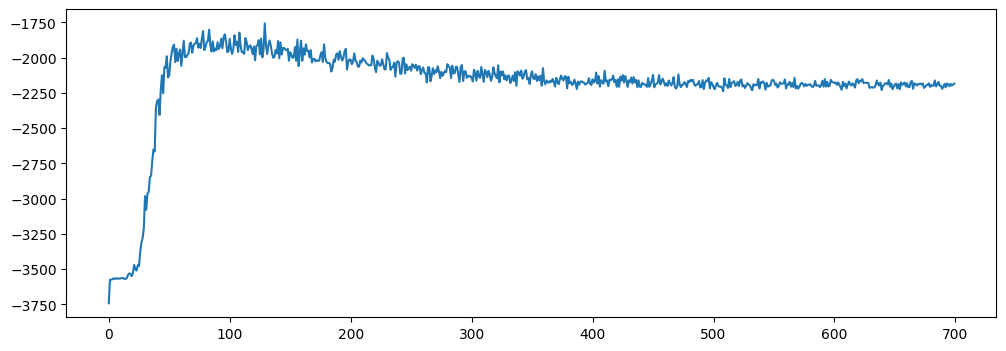

In [8]:
plt.figure(figsize=(12, 4))
plt.plot(np.arange(700), X)
plt.show()